In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

from celerite import plot_setup
plot_setup.setup(auto=False)

In [2]:
import kplr
import copy
import emcee3
import pickle
# import fitsio
from astropy.io import fits
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import transit

from celerite.plot_setup import setup, get_figsize, COLORS

import celerite
from celerite import terms, modeling

In [3]:
# class RotationTerm(terms.Term):
#     parameter_names = ("log_amp", "log_timescale", "log_period", "log_factor")
    
#     def get_real_coefficients(self, params):
#         log_amp, log_timescale, log_period, log_factor = params
#         f = np.exp(log_factor)
#         return (
#             np.exp(log_amp) * (1.0 + f) / (2.0 + f),
#             np.exp(-log_timescale),
#         )
    
#     def get_complex_coefficients(self, params):
#         log_amp, log_timescale, log_period, log_factor = params
#         f = np.exp(log_factor)
#         return (
#             np.exp(log_amp) / (2.0 + f),
#             0.0,
#             np.exp(-log_timescale),
#             2*np.pi*np.exp(-log_period),
#         )

class TransitModel(modeling.Model):
    parameter_names = ("mean_flux", "log_period", "log_ror", "log_duration",
                       "t0", "impact", "q1", "q2")

    def __init__(self, texp, *args, **kwargs):
        self.texp = texp
        super(TransitModel, self).__init__(*args, **kwargs)

    def get_value(self, t):
        system = transit.SimpleSystem(
            period=np.exp(self.log_period),
            ror=np.exp(self.log_ror),
            duration=np.exp(self.log_duration),
            t0=self.t0,
            impact=self.impact,
            q1=self.q1,
            q2=self.q2
        )
        lc = system.light_curve(t, texp=self.texp)
        return 1e3 * (lc - 1.0) + self.mean_flux

**Generate Fake Transit Data from a Real Kepler Light Curve**

**Load Spitzer Data**

In [4]:
from sklearn.externals import joblib

In [5]:
pwdSptzr  = '/Users/jonathan/Research/Planets/WASP52/analysis/'
saveDir   = 'SaveFiles/SaveState/' 
saveName  = 'save_state_r61517056_2457927.95867_FULL.pickle.save'
# glob(saveDir + '*save_state*FULL*')

load_pickle_dict = joblib.load(pwdSptzr + saveDir + saveName)# + 'FULL' + '.pickle.save')
for key in load_pickle_dict.keys():
    exec(key + "= load_pickle_dict['"+key+"']", globals(), locals())

In [6]:
from statsmodels.robust import scale
from scipy.signal import medfilt
def clipOutliers(array, nBins=101, nSig=10):
        if not (nBins % 2):
            print('nBins must be odd; `clipOutliers` is adding 1')
            nBins += 1
        
        medfilt_array   = medfilt(array, nBins)
        mad_array       = scale.mad(array)
        outliers        = abs(array - medfilt_array) > nSig * mad_array
        array[outliers] = medfilt_array[outliers]
        
        return array

In [7]:
photmetry_2p5[photmetry_2p5>41700].size

182

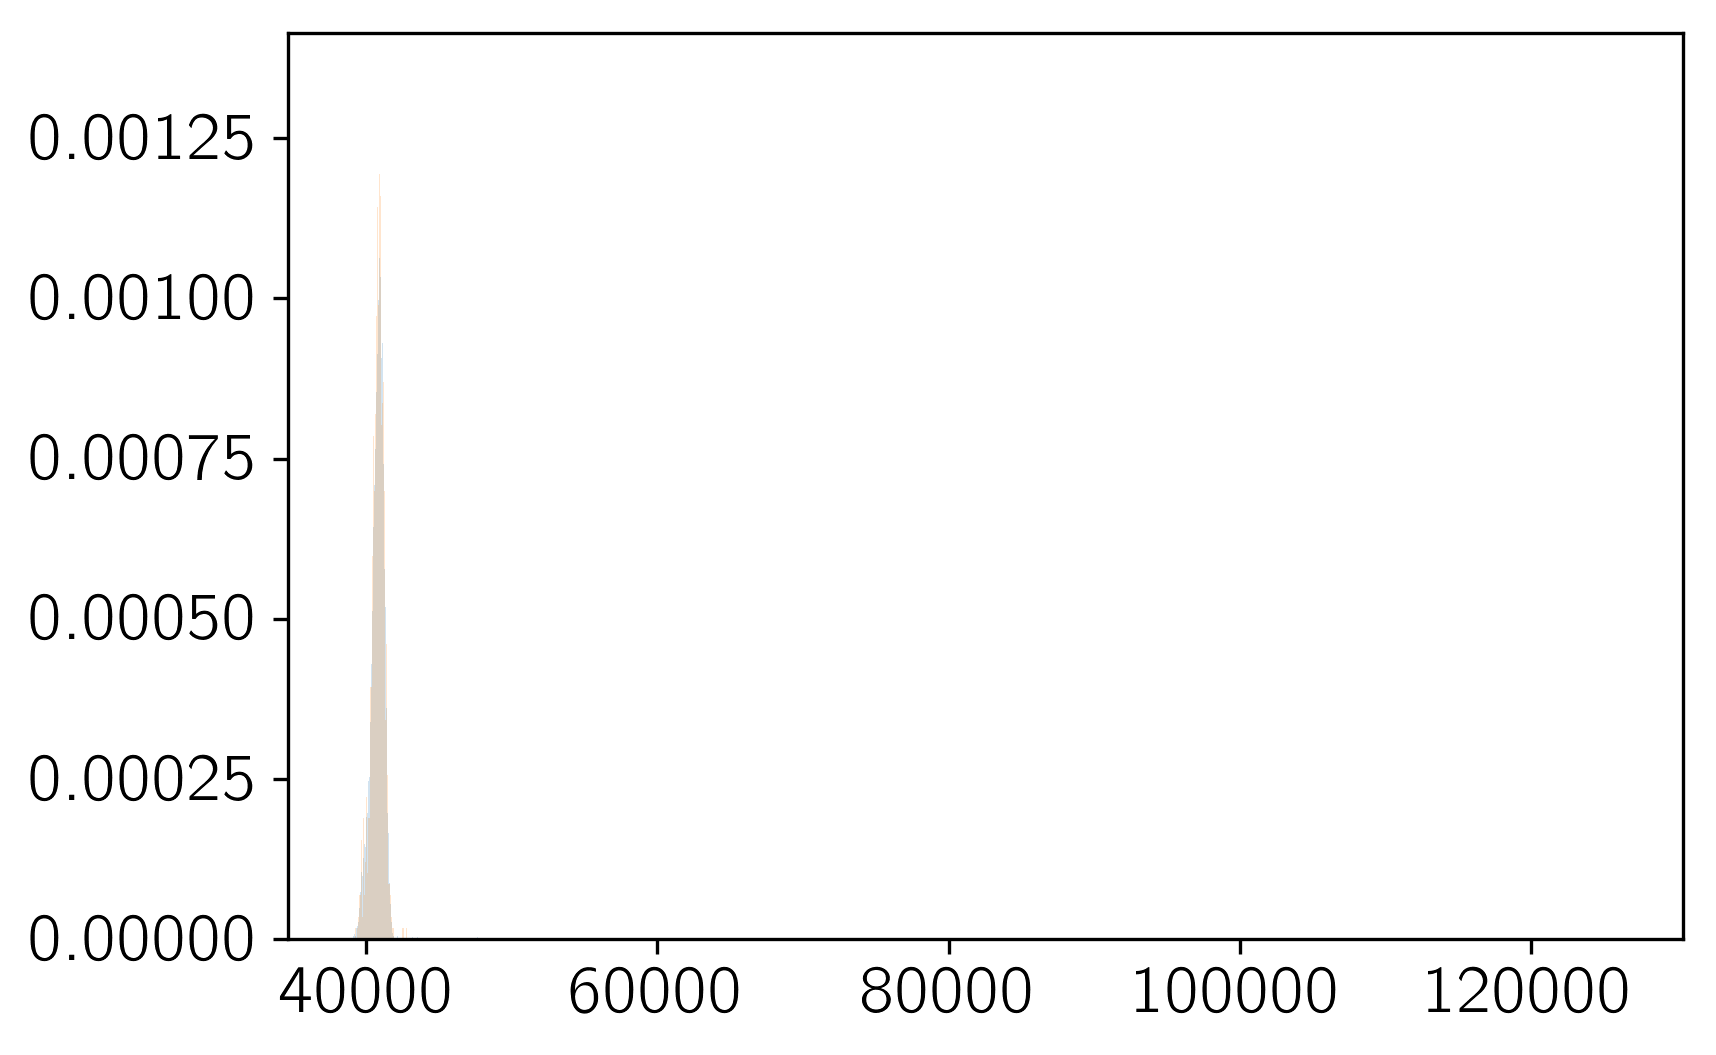

In [8]:
plt.hist(photmetry_2p5, bins=photmetry_2p5.size//10, normed=True, alpha=0.2);
plt.hist(clipOutliers(photmetry_2p5), bins=photmetry_2p5.size//10, normed=True, alpha=0.2);

In [9]:
photmetry_2p5 = clipOutliers(photmetry_2p5, nSig=5)
photmetry_2p5_err = clipOutliers(photmetry_2p5_err, nSig=5)

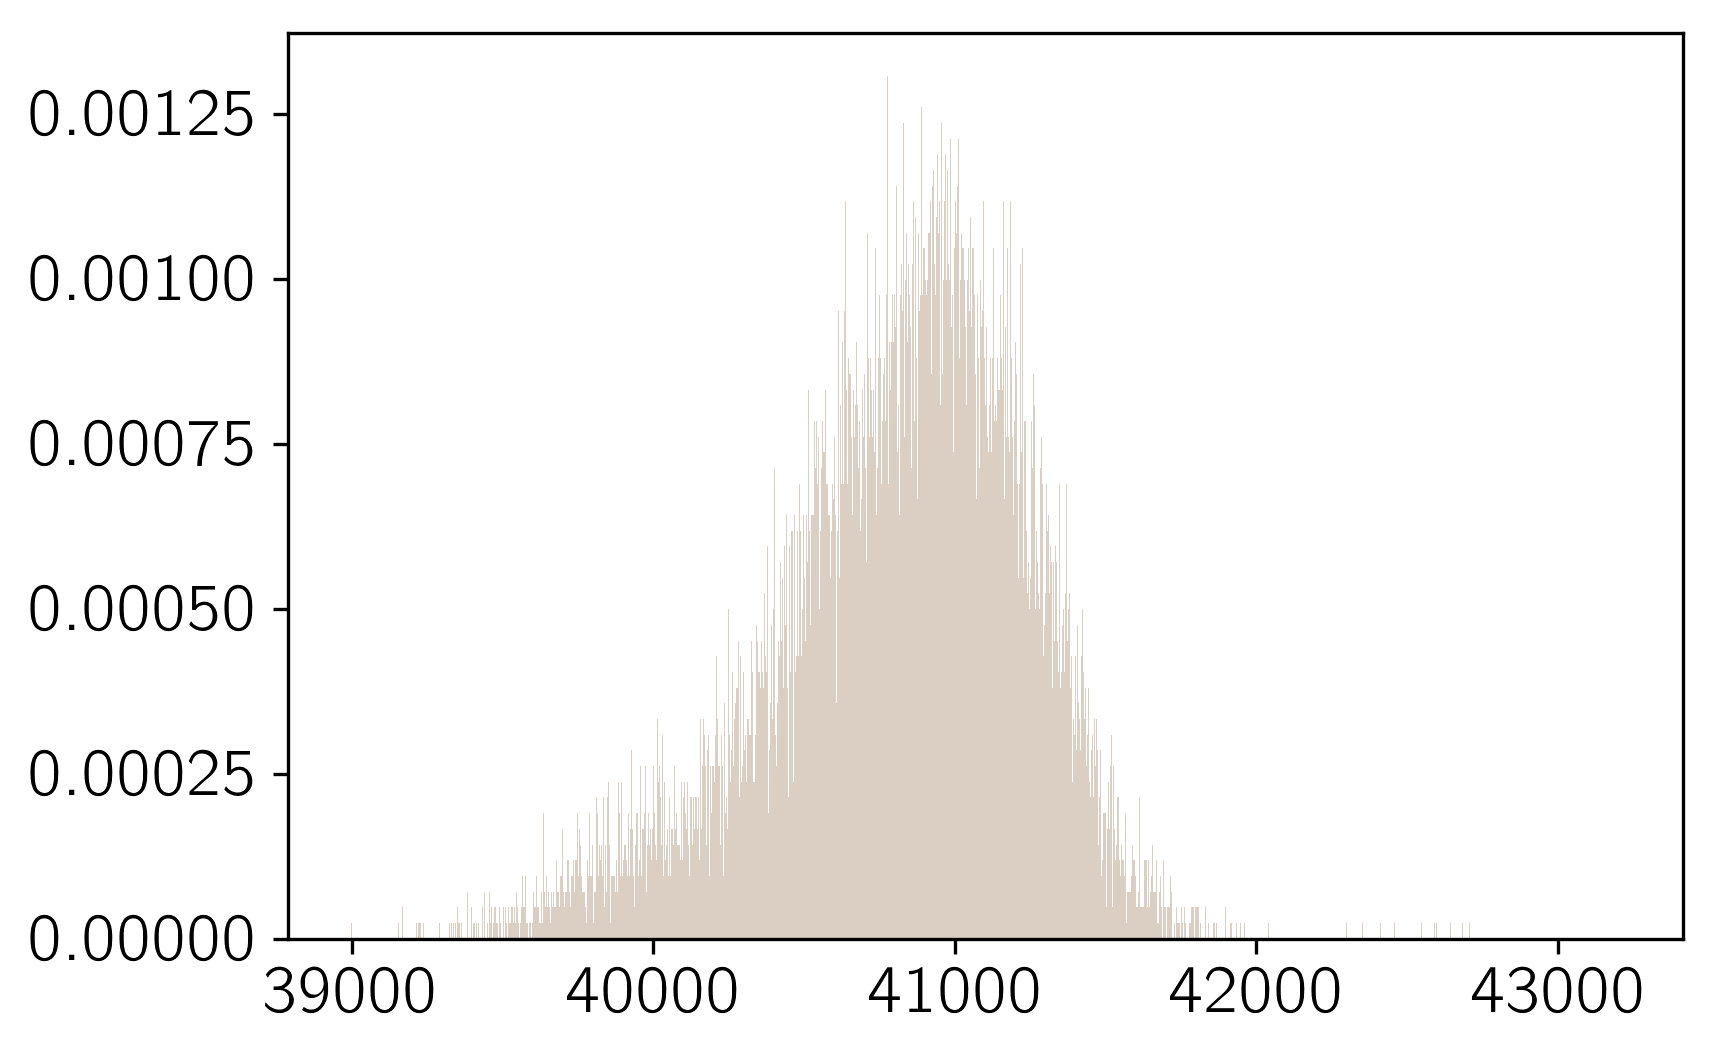

In [10]:
plt.hist(photmetry_2p5, bins=photmetry_2p5.size//10, normed=True, alpha=0.2);
plt.hist(clipOutliers(photmetry_2p5), bins=photmetry_2p5.size//10, normed=True, alpha=0.2);

**Allocate Spitzer Data for Celerite Example**

In [11]:
from exoparams import PlanetParams

wasp52_par = PlanetParams('WASP-52 b')

iPeriod   = wasp52_par.per.value
iTCenter  = wasp52_par.t0.value-2400000.5
iBImpact  = wasp52_par.b.value
iRsAp     = 1.0/wasp52_par.ar.value
iEdepth   = 100/1e6
iTdepth   = wasp52_par.depth.value
iEcc      = wasp52_par.ecc.value
iOmega    = wasp52_par.om.value

initParams_in = np.array([iPeriod, iTCenter, iBImpact, iRsAp, iEdepth, iTdepth, iEcc, iOmega])
# plot(timeCube, batman_wrapper(initParams_in, timeCube, transittype="primary"));
# plot(timeCube, batman_wrapper(initParams_in, timeCube, transittype="secondary"));

In [12]:
BIGNUM        = 1e10

period_range  = 0.0, BIGNUM
tcenter_range = iTCenter - 0.05, iTCenter + 0.05
bimpact_range = -1.0, 1.0
RsAp_range    = 0.0, BIGNUM
edepth_range  = 0.0, 1.0
tdepth_range  = 1e-10, 0.05
ecc_range     = 0.0, 1.0
omega_range   = 0.0, 360.

# params_dict = dict( Period   = dict(value=iPeriod  , fit=False, priorRange=period_range , priorType='uniform', index=0),
#                     TCenter  = dict(value=iTCenter , fit=True , priorRange=tcenter_range, priorType='uniform', index=1),
#                     BImpact  = dict(value=iBImpact , fit=False, priorRange=bimpact_range, priorType='uniform', index=2),
#                     RsAp     = dict(value=iRsAp    , fit=False, priorRange=RsAp_range   , priorType='uniform', index=3),
#                     Edepth   = dict(value=iEdepth  , fit=False , priorRange=edepth_range , priorType='uniform', index=4),
#                     Tdepth   = dict(value=iTdepth  , fit=True , priorRange=tdepth_range , priorType='uniform', index=5),
#                     Ecc      = dict(value=iEcc     , fit=False, priorRange=ecc_range    , priorType='uniform', index=6),
#                     Omega    = dict(value=iOmega   , fit=False, priorRange=omega_range  , priorType='uniform', index=7))

In [13]:
# from pandas import DataFrame
# DataFrame(params_dict)

In [14]:
weirdErr = [np.where(photmetry_2p5_err<=np.sqrt(photmetry_2p5))[0]]
photmetry_2p5_err[weirdErr] = np.sqrt(photmetry_2p5)[weirdErr]

** Assign Spitzer Data to Celerite Tutorial Variable **

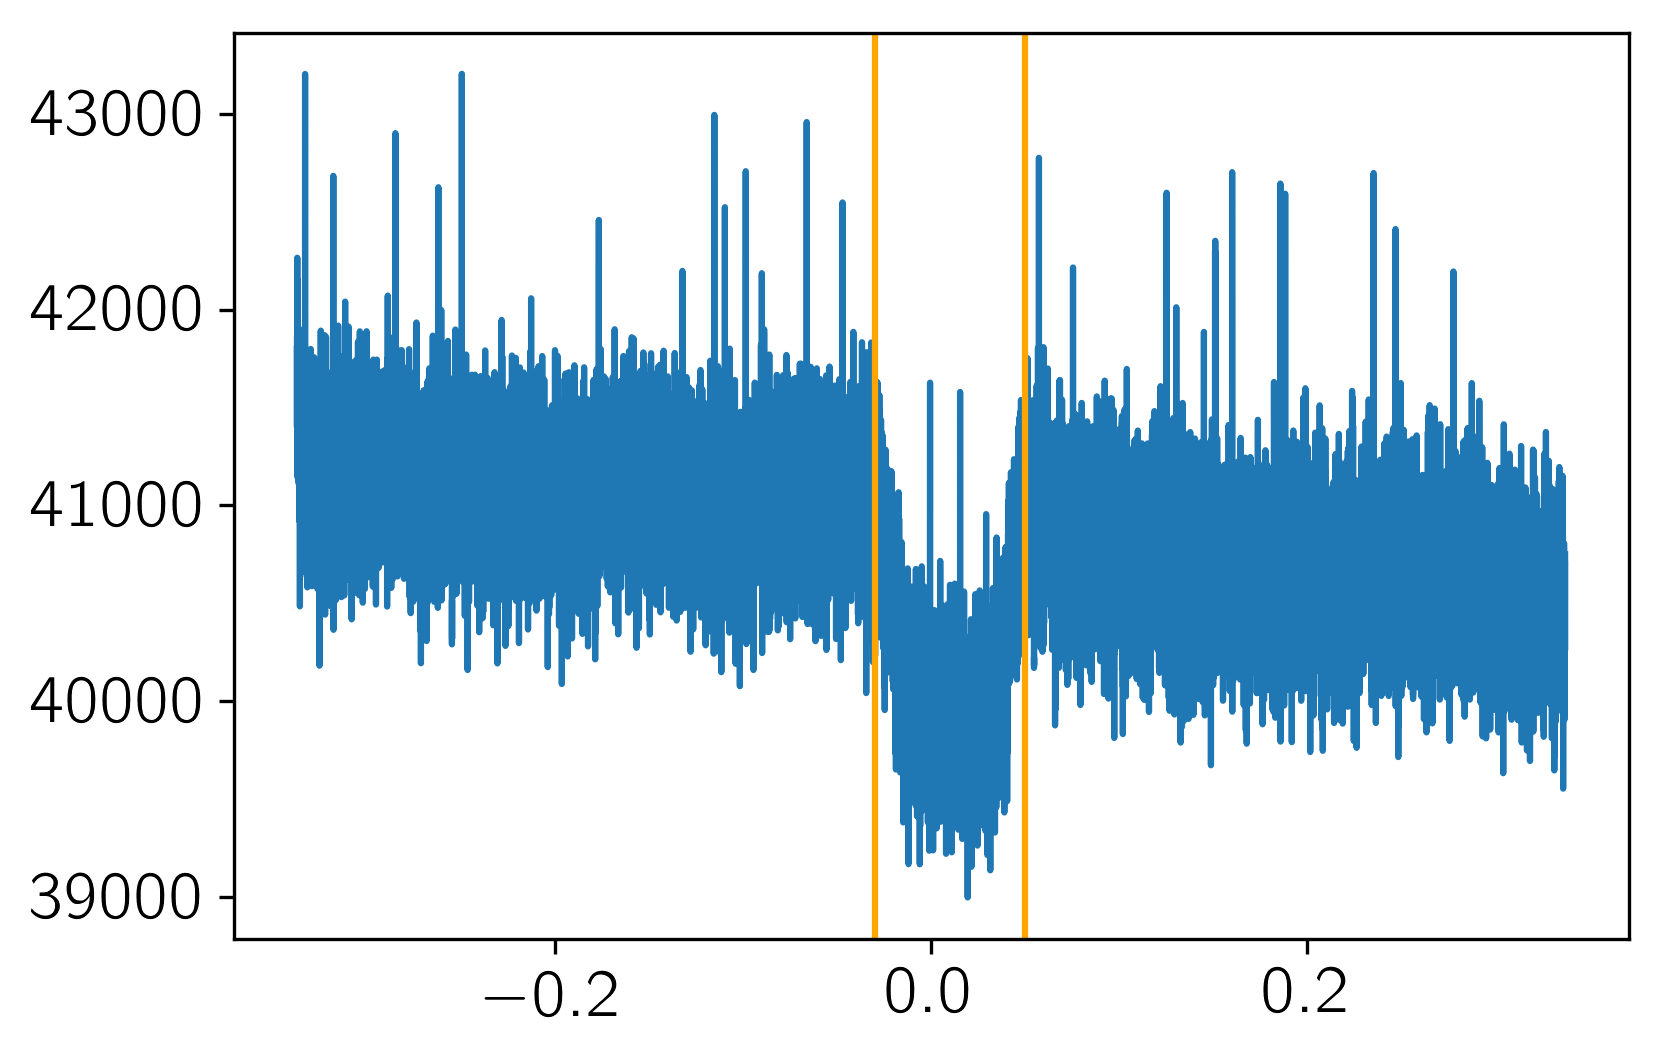

In [19]:
t     = timeCube
y     = photmetry_2p5
yerr  = photmetry_2p5_err

plt.plot(t-t.mean(),y)
plt.axvline(-0.03,color='orange')
plt.axvline( 0.05,color='orange')

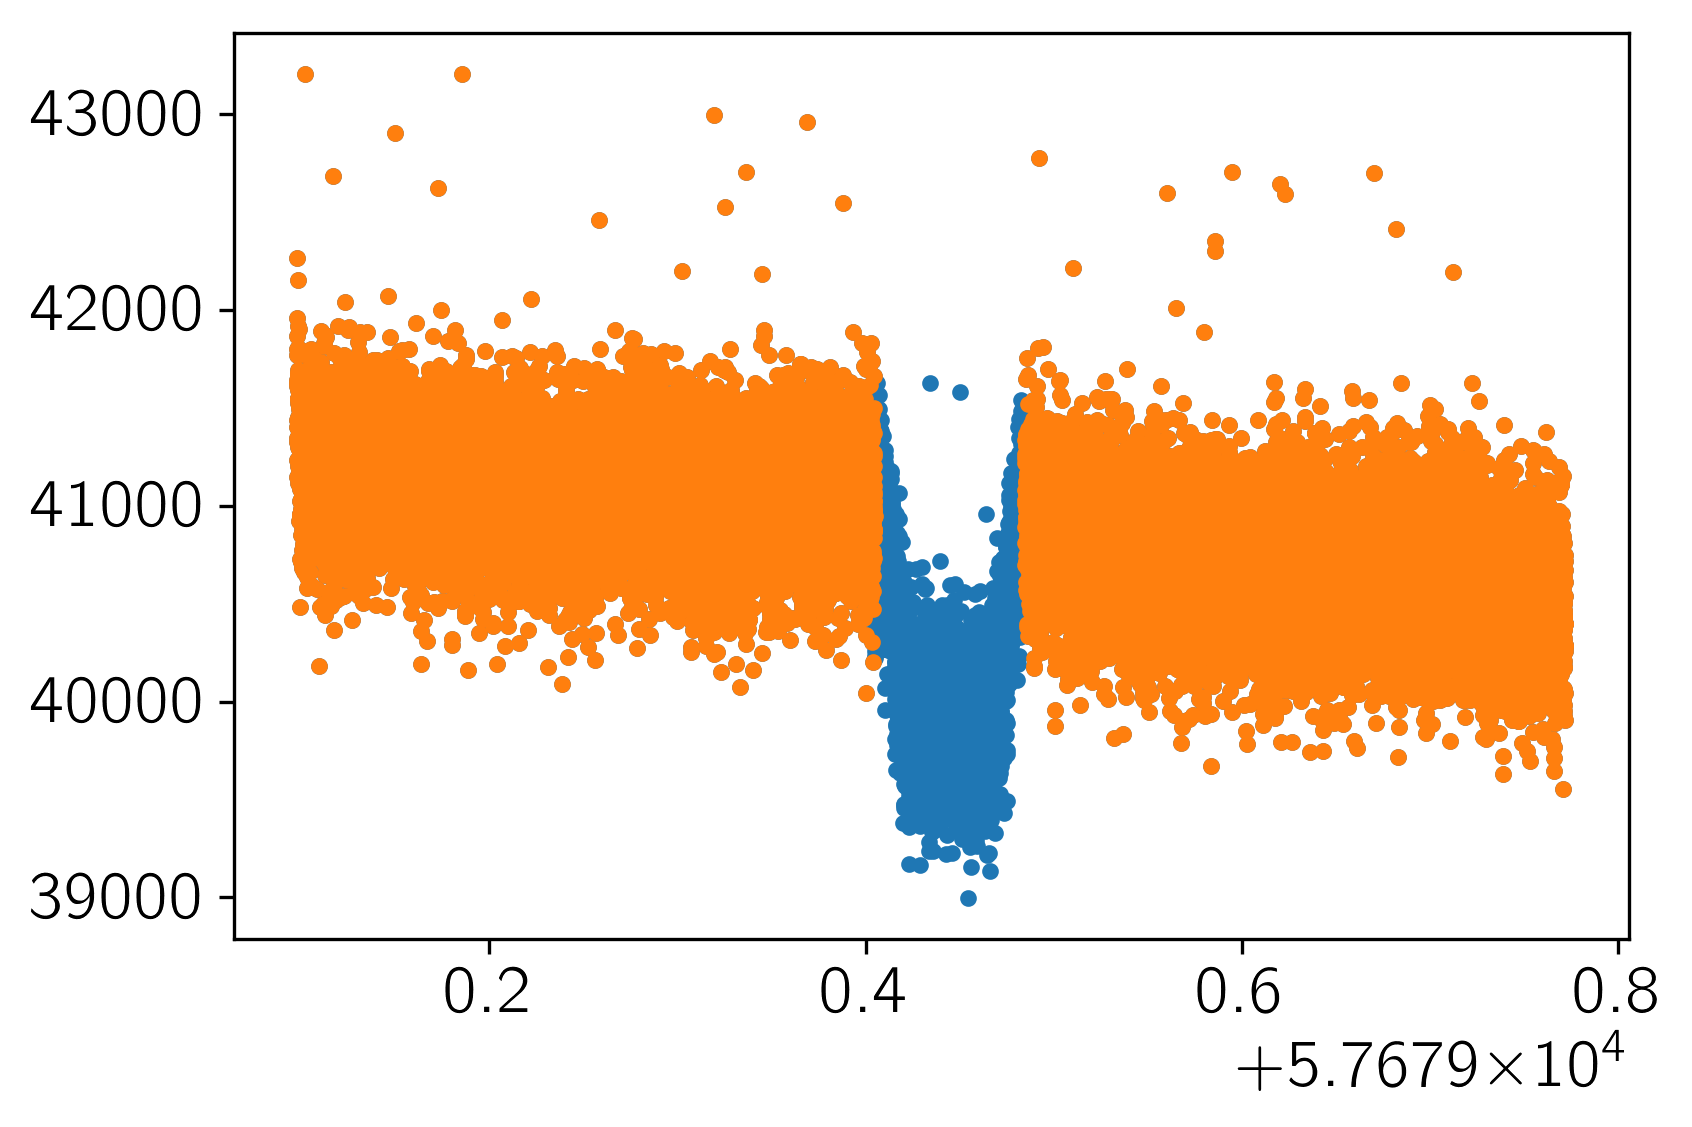

In [23]:
oot = [abs(timeCube-timeCube.mean()-0.01) >.04];
plt.plot(timeCube, photmetry_2p5,'.');
plt.plot(timeCube[oot], photmetry_2p5[oot],'.');

In [34]:
nData= 10000
nSkip= photmetry_2p5.size // nData

# useTime   = (timeCube-timeCube.mean()<-0.035) + (timeCube-timeCube.mean()>0.05)
OutOfTransit  = [abs(timeCube-timeCube.mean()-0.01) >.04];

tTrain    = np.ascontiguousarray(timeCube[OutOfTransit][::nSkip], dtype=np.float64)
yTrain    = np.ascontiguousarray(photmetry_2p5[OutOfTransit][::nSkip], dtype=np.float64)
yerrTrain = np.ascontiguousarray(photmetry_2p5_err[OutOfTransit][::nSkip], dtype=np.float64)

tTest     = np.ascontiguousarray(timeCube[::nSkip], dtype=np.float64)
yTest     = np.ascontiguousarray(photmetry_2p5[::nSkip], dtype=np.float64)
yerrTest  = np.ascontiguousarray(photmetry_2p5_err[::nSkip], dtype=np.float64)

overTrain = yTrain.size - nData
if overTrain > 0:
    yTrain    = yTrain[overTrain//2:-overTrain//2]
    yerrTrain = yerrTrain[overTrain//2:-overTrain//2]
    tTrain    = tTrain[overTrain//2:-overTrain//2]

overTest = yTest.size - nData
if overTest > 0:
    yTest    = yTest[overTest//2:-overTest//2]
    yerrTest = yerrTest[overTest//2:-overTest//2]
    tTest    = tTest[overTest//2:-overTest//2]

# Normalize the Data
medTrain = np.median(yTrain)
yTrain = (yTrain / medTrain - 1.0) * 1e3
yerrTrain *= 1e3 / medTrain

tTrain = tTrain -  tTrain.mean()

# Normalize the Data
medTest = np.median(yTest)
yTest = (yTest / medTrain - 1.0) * 1e3
yerrTest *= 1e3 / medTrain

tTest = tTest -  tTest.mean()

In [35]:
print(' ',medTest, yTest.mean(), yerrTest.mean(), tTest.mean(),'\n ',medTrain, yTrain.mean(), yerrTrain.mean(), tTrain.mean())

  40851.5204285 -3.25917454133 5.87992897026 -1.16415321827e-13 
  40918.9149321 -0.316014638991 5.89823687378 7.18573573977e-12


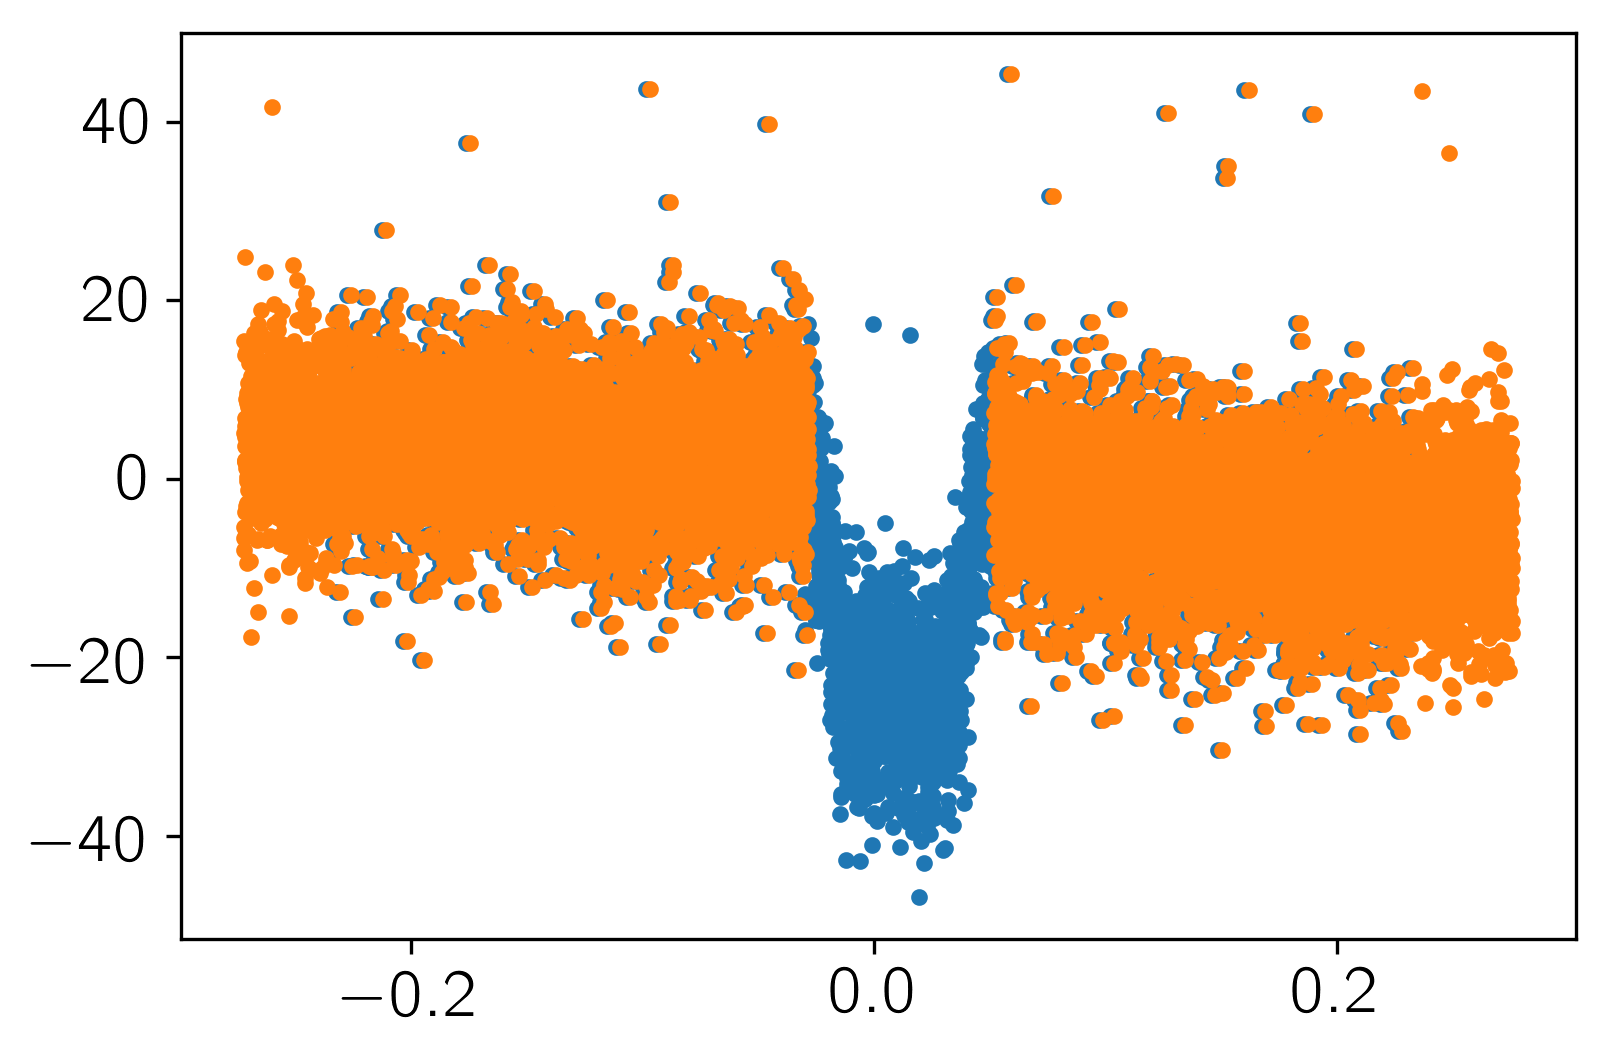

In [36]:
plt.plot(tTest, yTest,'.')
plt.plot(tTrain, yTrain,'.')

**Check Mean Function Prior Limits**

In [37]:
print('mean flux\t\t', -0.5< 0.0 <0.5)
print('period\t\t\t', np.log(iPeriod - .1)<np.log(iPeriod)<np.log(iPeriod + .1))
print('Rp / Rs\t\t\t', np.log(tdepth_range[0])<np.log(iTdepth)<np.log(tdepth_range[1]))
print('duration\t\t', np.log(0.01)<np.log(0.08)<np.log(0.16))
print('tCenter-iTCenter\t', -0.1 < 0.0 < 0.1)
print('impact parameter\t', bimpact_range[0] < iBImpact < bimpact_range[1])
print('q1\t\t\t', 0.<0.1< 1.)
print('q2\t\t\t', 0.<0.1< 1.)

mean flux		 True
period			 True
Rp / Rs			 True
duration		 True
tCenter-iTCenter	 True
impact parameter	 True
q1			 True
q2			 True


**Check gpTrain Function Prior Limits**

In [38]:
print("log_amp", -10.0< np.log(np.var(np.diff(y)))<5.0)
print("log_timescale", -5.0<np.log(0.5*t.max())<5.)
print("log_period", -3.0 <np.log(4.5) <5.0)
print("log_factor", -5.0 < 0.0 < 5.0)

log_amp False
log_timescale False
log_period True
log_factor True


In [39]:
# Set up the gpTrain model
mean = TransitModel(
    np.median(np.diff(tTrain)),
    0.0,   # mean_flux
    np.log(iPeriod),    # period
    np.log(iTdepth),  # Rp / Rs
    np.log(0.08),    # duration
    0.0, # tCenter - mean(t)
    iBImpact,            # impact parameters
    0.1,            # q_1
    0.1,            # q_2
    bounds=[
        (-0.5,0.5), # mean flux range
        (np.log(iPeriod), np.log(iPeriod)), # log period range
        np.log([.01,.05]), # log transit depth range
        (np.log(0.07),np.log(0.10)), # log transit duration range
        (-0.05, 0.05), # transit center range
        (-.75,.75), # impact parameter range
        (0., 0.5),  # q1 range
        (0., 0.5)   # q2 range
        ]
)

# kernel = RotationTerm(
#     -5,   # log_amp
#     np.log(0.1*tTrain.max()), # log_timescale
#     np.log(0.05),         # log_period
#     0.0,                 # log_factor
#     bounds=dict(
#         log_amp=(-10.0, 5),
#         log_timescale=(-10.0, 5),#np.log(0.075)),
#         log_period=(-10.0, 5),#np.log(0.075)),
#         log_factor=(-5.0, 5.0),
#     ),
# )

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

kernel += terms.JitterTerm(
    log_sigma=np.log(0.5*yerrTrain.min()),
    bounds=[(-5.0, 5.0)],
)

gpTrain = celerite.GP(kernel, mean=mean, fit_mean=True)
gpTrain.compute(tTrain, yerrTrain)
print("Initial log-likelihood: {0}".format(gpTrain.log_likelihood(yTrain)))

Initial log-likelihood: -33840.86669194905


**Maximize the Log-Likelihood of the Transit and the gpTrain Model**

In [40]:
gpTrain.parameter_vector

array([ 11.38537319,  -0.34657359,   1.09861229,  11.0387996 ,
         0.        ,   1.09861229,   0.88947693,   0.        ,
         0.55948995,  -3.60822155,  -2.52572864,   0.        ,
         0.6       ,   0.1       ,   0.1       ])

In [44]:
gpTrain.freeze_parameter('mean:log_period')
gpTrain.parameter_names

('kernel:terms[0]:log_S0',
 'kernel:terms[0]:log_Q',
 'kernel:terms[0]:log_omega0',
 'kernel:terms[1]:log_S0',
 'kernel:terms[1]:log_Q',
 'kernel:terms[1]:log_omega0',
 'kernel:terms[2]:log_sigma',
 'mean:mean_flux',
 'mean:log_period',
 'mean:log_ror',
 'mean:log_duration',
 'mean:t0',
 'mean:impact',
 'mean:q1',
 'mean:q2')

** Freeze Period **

In [48]:
print(gpTrain.get_parameter_names())
print()
print('mean:log_period' in gpTrain.get_parameter_names())

('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_Q', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0', 'kernel:terms[2]:log_sigma', 'mean:mean_flux', 'mean:log_ror', 'mean:log_duration', 'mean:t0', 'mean:impact', 'mean:q1', 'mean:q2')

False


** Unthaw everything for initial range test **

In [50]:
gpTrain.thaw_all_parameters()

**Freeze All Non-kernel Parameters for Out of Transit Frequency Range Test**

In [51]:
gpTrain.freeze_all_parameters()
for pname in gpTrain.parameter_names:
    if 'kernel' in pname:
        gpTrain.thaw_parameter(pname)

In [52]:
print(gpTrain.get_parameter_names())

('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_Q', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0', 'kernel:terms[2]:log_sigma')


In [55]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y) + np.sum(np.sqrt(gp.parameter_vector**2.))

# Optimize with random restarts
p0 = gpTrain.get_parameter_vector()
bounds = gpTrain.get_parameter_bounds()
rTrain = minimize(neg_log_like, p0, method="L-BFGS-B", bounds=bounds, args=(yTrain, gpTrain))
print(rTrain)
gpTrain.set_parameter_vector(rTrain.x)
ml_params = np.array(rTrain.x)
print("Maximum log-likelihood: {0}".format(gpTrain.log_likelihood(yTrain)))

# Compute the maximum likelihood predictions
xPred = np.linspace(tTrain.min(), tTrain.max(), 5000)
trendTrain = gpTrain.predict(yTrain, tTrain, return_cov=False)
trendTrain -= gpTrain.mean.get_value(tTrain) - gpTrain.mean.mean_flux
muPred, varPred = gpTrain.predict(yTrain, xPred, return_var=True)
stdPred = np.sqrt(varPred)
mean_muPred = gpTrain.mean.get_value(xPred)
muPred -= mean_muPred
# wnTrain = np.exp(2*gpTrain.kernel.terms[1].log_sigma)
ml_yerrTrain = np.sqrt(yerrTrain**2)# + wnTrain)

      fun: 33610.594683063246
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02037268, -0.03856258, -0.04292815, -0.94078132, -0.9444193 ,
        0.99826138,  0.0865839 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 720
      nit: 64
   status: 0
  success: True
        x: array([  5.77582531e-01,  -3.16888589e+00,   5.00337980e+00,
        -5.18277684e-06,  -1.65084367e-04,   3.48698204e-05,
         1.40174107e+00])
Maximum log-likelihood: -33592.949448483414


**Plot the maximum likelihood predictions**

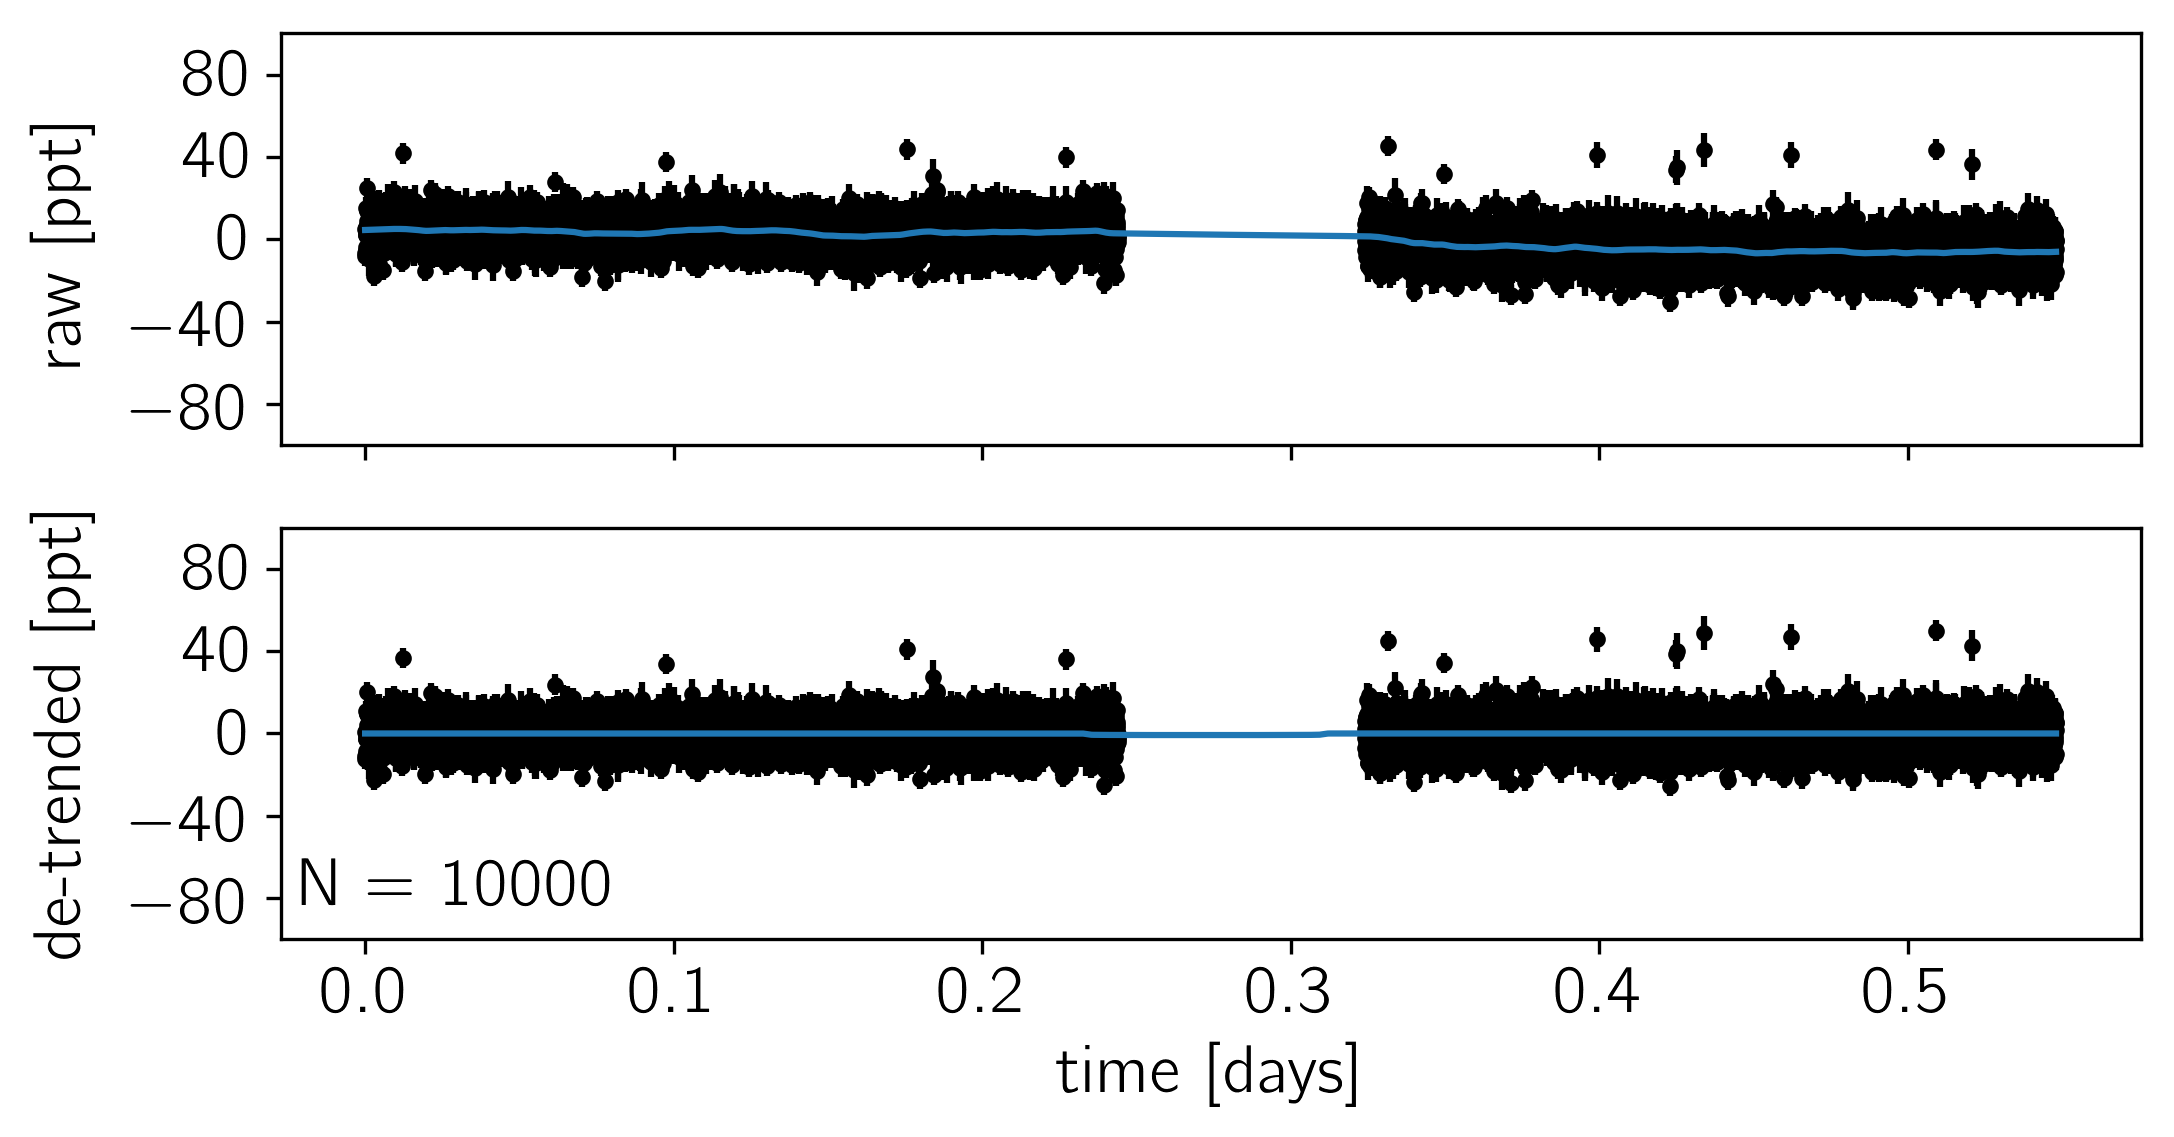

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=get_figsize(1, 2))
ax1.errorbar(tTrain - tTrain.min(), yTrain, yerr=ml_yerrTrain, fmt=".k", capsize=0, zorder=-1)
ax1.plot(xPred - tTrain.min(), muPred, zorder=100)
ax1.set_ylim(-100, 100)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylabel("raw [ppt]")
ax1.yaxis.set_label_coords(-0.1, 0.5)

ax2.errorbar(tTrain - tTrain.min(), yTrain - trendTrain, yerr=ml_yerrTrain, fmt=".k", capsize=0, zorder=-1)

ax2.plot(xPred - tTrain.min(), mean_muPred - gpTrain.mean.mean_flux, zorder=100)
# ax2.set_xlim(0, t.max()-t.min())
ax2.set_ylim(-100, 100)

ax2.annotate("N = {0}".format(len(tTrain)), xy=(0, 0),
             xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom")

ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.set_ylabel("de-trended [ppt]")
ax2.set_xlabel("time [days]")
ax2.yaxis.set_label_coords(-0.1, 0.5)
# fig.savefig("transit-ml.pdf")

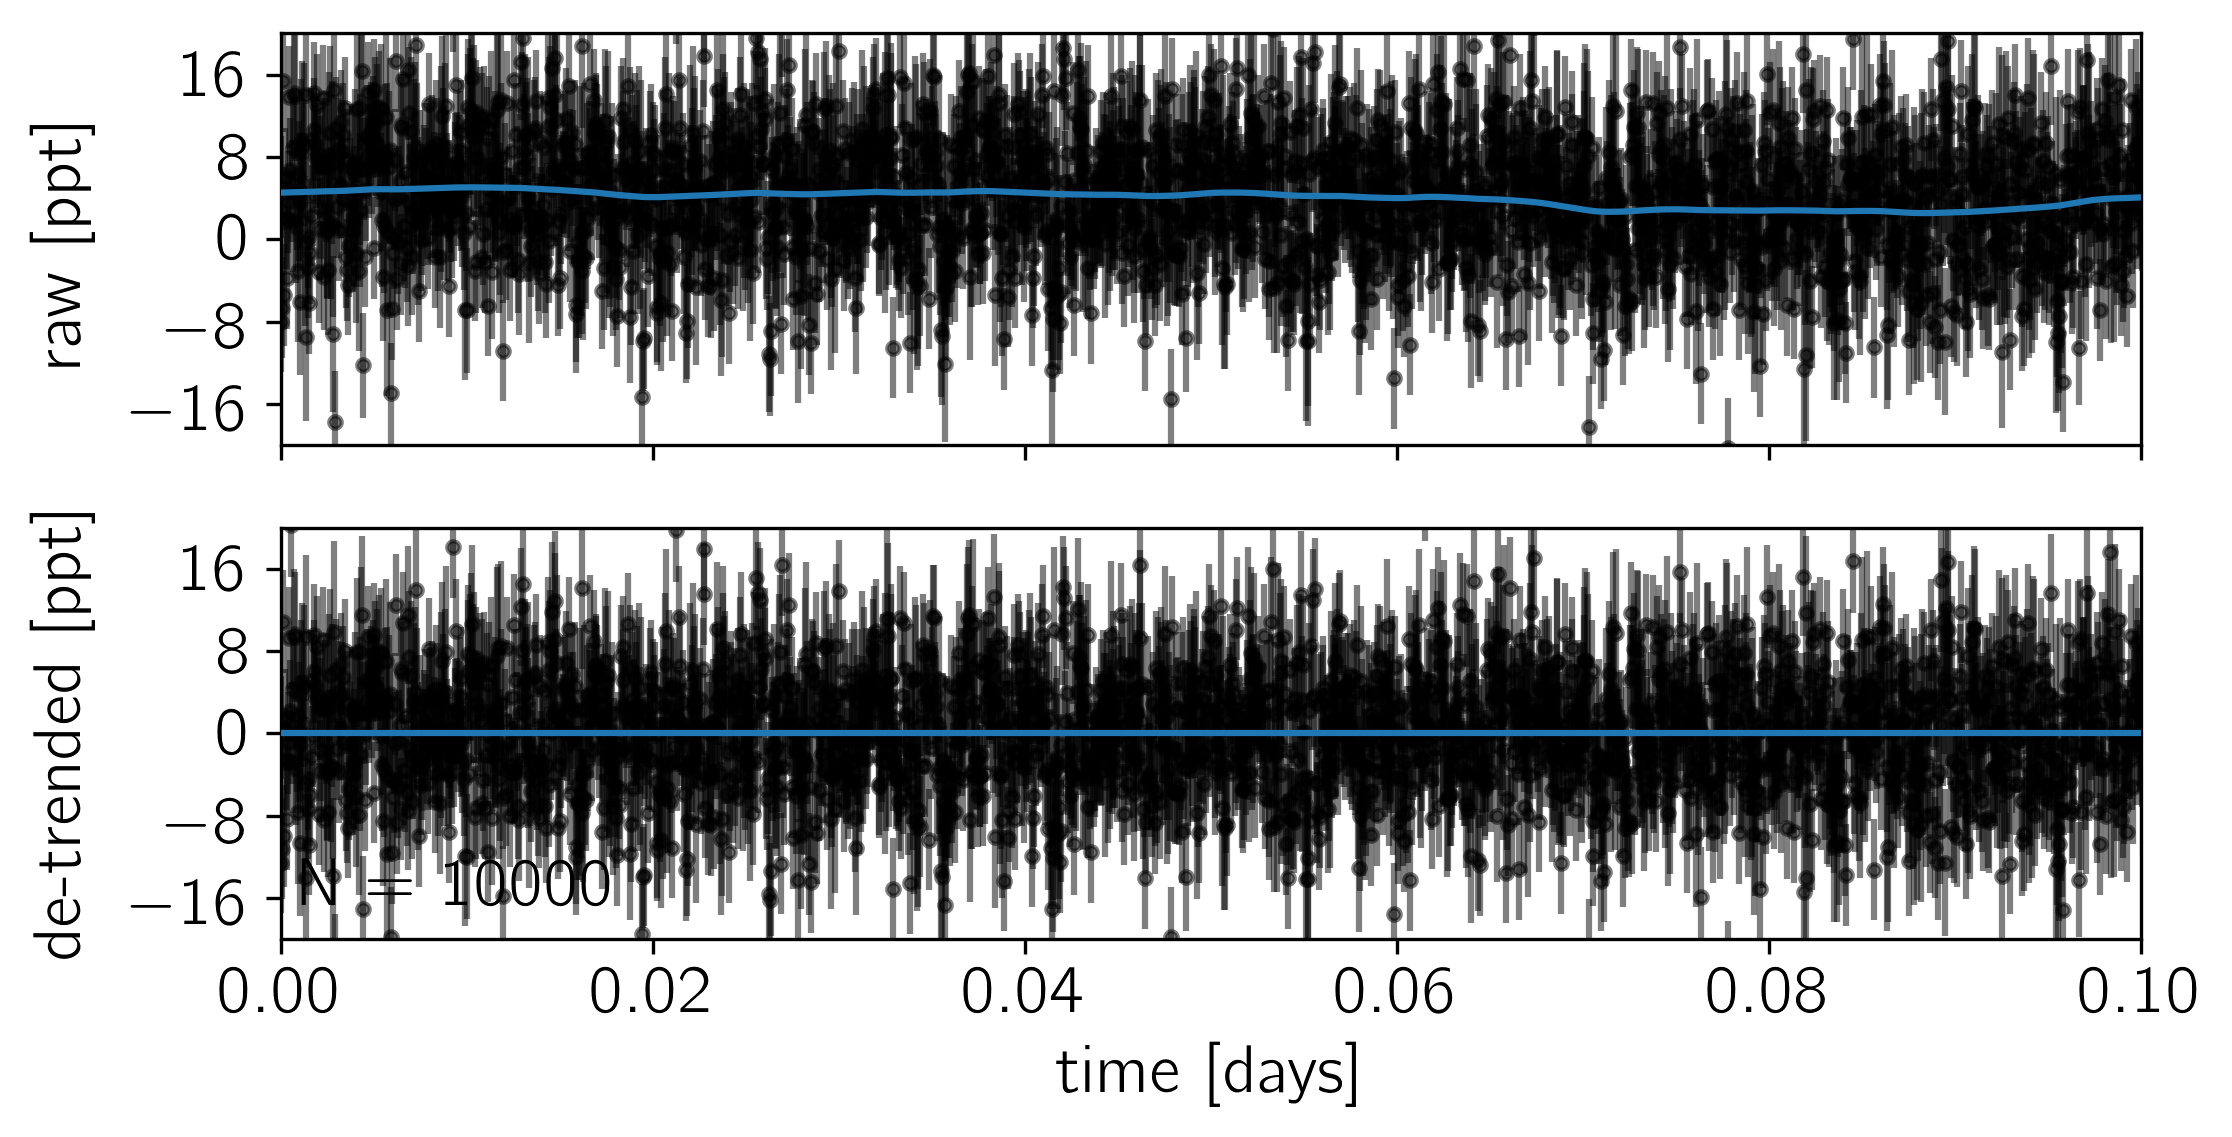

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=get_figsize(1, 2))
ax1.errorbar(tTrain - tTrain.min(), yTrain, yerr=ml_yerrTrain, fmt=".k", capsize=0, zorder=-1, alpha=0.5)
ax1.plot(xPred - tTrain.min(), muPred, zorder=100)
ax1.set_ylim(-20, 20)
ax1.set_xlim(0, .1)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylabel("raw [ppt]")
ax1.yaxis.set_label_coords(-0.1, 0.5)

ax2.errorbar(tTrain - tTrain.min(), yTrain - trendTrain, yerr=ml_yerrTrain, fmt=".k", capsize=0, zorder=-1, alpha=0.5)

ax2.plot(xPred - tTrain.min(), mean_muPred - gpTrain.mean.mean_flux, zorder=100)
# ax2.set_xlim(0, t.max()-t.min())
ax2.set_ylim(-20, 20)
ax1.set_xlim(0, .1)
ax2.annotate("N = {0}".format(len(tTrain)), xy=(0, 0),
             xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom")

ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.set_ylabel("de-trended [ppt]")
ax2.set_xlabel("time [days]")
ax2.yaxis.set_label_coords(-0.1, 0.5)
# fig.savefig("transit-ml.pdf")

In [59]:
# with open("transit.pkl", "wb") as f:
#     pickle.dump((gpTrain, y, true_model.get_parameter_dict()), f, -1)

# Do the MCMC
def log_prob(params):
    gpTrain.set_parameter_vector(params)
    lp = gpTrain.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gpTrain.log_likelihood(y) + lp

# Initialize
print("Running MCMC sampling...")
ndim = len(ml_params)
nwalkers = 32
pos = ml_params + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = ml_params + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)

# Sample
sampler = emcee3.Sampler(backend=emcee3.backends.HDFBackend("transit.h5"))
with emcee3.pools.InterruptiblePool() as pool:
    ensemble = emcee3.Ensemble(emcee3.SimpleModel(log_prob), pos, pool=pool)
    sampler.run(ensemble, 30000, progress=True)

Running MCMC sampling...


ValueError: dimension mismatch

In [ ]:
true_params = true_model.get_parameter_dict()
names = gpTrain.get_parameter_names()
cols = ["log_period", "log_ror", "log_duration", "t0"]
inds = [names.index("mean:{0}".format(c)) for c in cols]
samples = np.array(sampler.get_coords(discard=10000, flat=True, thin=7))
samples = samples[:, inds]
samples[:, :-1] = np.exp(samples[:, :-1])
truths = np.array([true_params[k] for k in cols])
truths[:-1] = np.exp(truths[:-1])
fig = corner.corner(samples, truths=truths, smooth=0.5,
                    labels=[r"period", r"$R_\mathrm{P}/R_\star$", r"duration",
                            r"$t_0$"])
for ax in np.array(fig.axes).flatten():
    ax.xaxis.set_label_coords(0.5, -0.4)
    ax.yaxis.set_label_coords(-0.4, 0.5)
fig.savefig("transit-corner.pdf")

In [ ]:
plt.plot(sampler.get_coords()[:, :, names.index("mean:impact")]);

In [ ]:
from scipy.linalg import cho_solve, cho_factor

p0 = gpTrain.get_parameter_vector()
fast_timing = %timeit -o log_prob(p0)

def _time_this():
    K = gpTrain.get_matrix(include_diagonal=True)
    factor = cho_factor(K, overwrite_a=True)
    ld = 2.0 * np.sum(np.log(np.diag(factor[0])))
    resid = gpTrain.mean.get_value(t) - y
    ll = -0.5*(np.dot(resid, cho_solve(factor, resid))+ld) + gpTrain.log_prior()

slow_timing = %timeit -o _time_this()

In [ ]:
samples = sampler.get_coords(discard=10000, flat=True)
names = gpTrain.get_parameter_names()
chain = sampler.get_coords(discard=10000)[:, :, names.index("mean:log_period")]
tau = np.mean(emcee3.autocorr.integrated_time(np.mean(chain, axis=1), c=5))
neff = len(samples) / tau
tau, neff

In [ ]:
import json
c = gpTrain.kernel.coefficients
with open("transit.json", "w") as f:
    json.dump(dict(
        N=len(t),
        J=len(c[0]) + len(c[2]),
        tau=tau,
        neff=neff,
        time=fast_timing.average,
        direct_time=slow_timing.average,
        nwalkers=nwalkers,
        nburn=10000,
        nsteps=30000,
        ndim=ndim,
    ), f)

In [ ]:
name_map = {
    'kernel:terms[0]:log_amp': "$\ln(B/\mathrm{ppt}^2)$",
    'kernel:terms[0]:log_timescale': "$\ln(L/\mathrm{day})$",
    'kernel:terms[0]:log_period': "$\ln(P_\mathrm{rot}/\mathrm{day})$",
    'kernel:terms[0]:log_factor': "$\ln(C)$",
    'kernel:terms[1]:log_sigma': "$\ln(\sigma/\mathrm{ppt})$",
    'mean:mean_flux': "$f_0/\mathrm{ppt}$",
    'mean:log_period': "$\ln(P_\mathrm{orb}/\mathrm{day})$",
    'mean:log_ror': "$\ln(R_p/R_\star)$",
    'mean:log_duration': "$\ln(T/\mathrm{day})$",
    'mean:t0': "$t_0/\mathrm{day}$",
    'mean:impact': "$b$",
    'mean:q1': "$q_1$",
    'mean:q2': "$q_2$",
}
params = list(zip(
    (name_map[n] for n in gpTrain.get_parameter_names()),
    gpTrain.get_parameter_bounds()
))

params[6] = "$\ln(P_\mathrm{orb}/\mathrm{day})$", ["\ln(7.9)", "\ln(8.1)"]
params[7] = "$\ln(R_p/R_\star)$", ["\ln(0.005)", "\ln(0.1)"]
params[8] = "$\ln(T/\mathrm{day})$", ["\ln(0.4)", "\ln(0.6)"]
with open("transit-params.json", "w") as f:
    json.dump(params, f)